this notebook is my attempt at seeing if reverberations will disappear in the spectrograms if I do some edge detection..

In [1]:
from make_training_data import mean_subtract_rowwise
import cv2
import numpy as np
from skimage.filters  import sobel
from skimage import measure
from skimage.morphology import skeletonize, convex_hull_image
from skimage.filters import threshold_otsu, threshold_local
from skimage import feature
import scipy.signal as signal 
import scipy.io.wavfile as wav
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000


In [2]:
%matplotlib notebook

In [78]:
fs, audio = wav.read('wavs//'+'Mic01_2018-05-28_03-42-15_1527471735.WAV')

In [79]:
calc_ind = lambda X : int(X*192000)

In [160]:
start, stop = 0, 1.5
start_ind, stop_ind = calc_ind(start), calc_ind(stop)

audio_segment = audio[start_ind:stop_ind]

In [187]:
f, t, S = signal.spectrogram(audio_segment, fs, nperseg=64, noverlap=0)
S = np.flipud(S)
mean_S = mean_subtract_rowwise(S)
if sum(mean_S.flatten()<=0.0) > 0 :
    mean_S += -np.min(mean_S) + 10.0**-5

In [188]:
log_meanS = 20*np.log10(mean_S)
log_S = np.copy(S)
if sum(S.flatten()<=0.0) > 0 :
    log_S += -np.min(mean_S) + 10.0**-5
    log_S = 20*np.log10(S)
else:
    log_S = 20*np.log10(S)

<IPython.core.display.Javascript object>


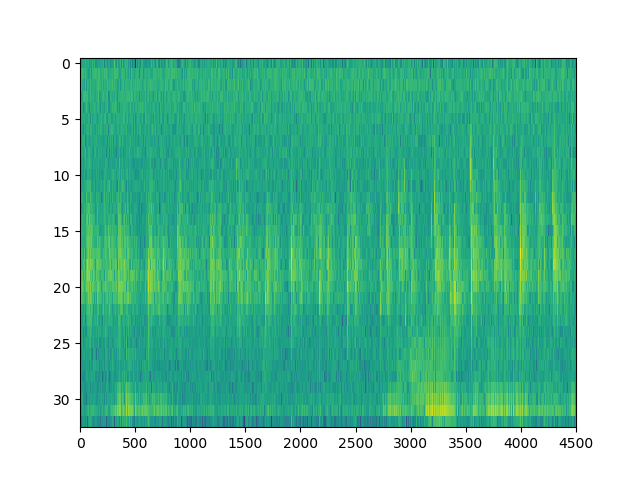

In [189]:
plt.figure()
plt.imshow(log_S, aspect='auto')

<IPython.core.display.Javascript object>


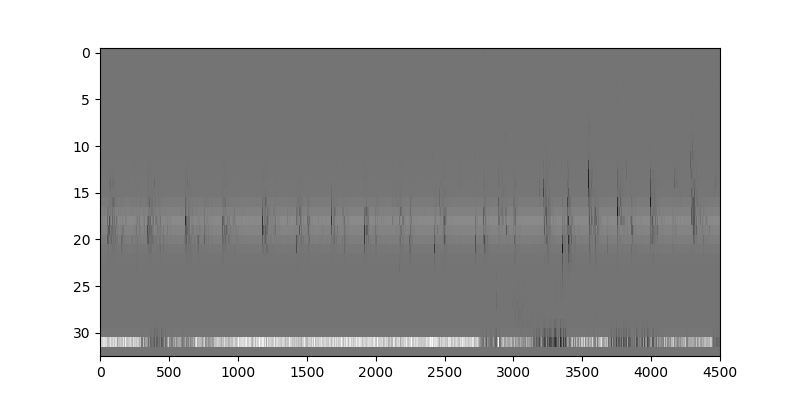

In [190]:
plt.figure(figsize=(8,4))
plt.imshow(log_meanS, aspect='auto', cmap='Greys')

Now, we see some kind of reverberation in the 300th FFt window. I'm going to try and see if doing some edge detection allows me to get rid of this reverberation.

In [191]:
threshold = np.percentile(log_meanS.flatten(),90)
S_sob = np.copy(log_meanS)
S_sob[S_sob<threshold] = -1 
S_sob[S_sob>threshold] = 1 
S_sob = np.uint8(S_sob)

In [192]:
# convert the image to 8bit first : 
S_8bit = np.copy(S)
S_8bit *= 1.0/np.max(S)
S_8bit *= 2**8 -1
S_8bit = np.uint8(S_8bit)
# threshold it 
ret,thresh = cv2.threshold(S_8bit,np.percentile(S_8bit.flatten(), 1),255,1)

otsu_thresh = threshold_otsu(S_8bit)
S_8bit_otsu = np.zeros(S_8bit.shape)
S_8bit_otsu[S_8bit>otsu_thresh] = 1 

block_size = 25
binary_adaptive = threshold_local(S_8bit, block_size)
S_8bit_adap = np.zeros(S_8bit.shape)
S_8bit_adap [ S_8bit > binary_adaptive] = 1 

<IPython.core.display.Javascript object>


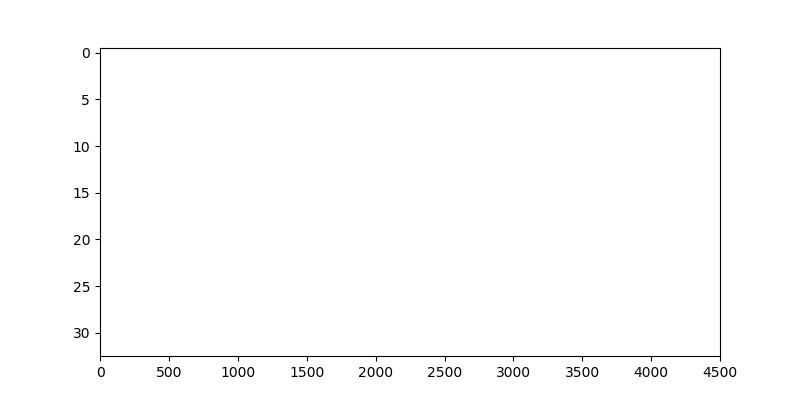

In [193]:
sobel_filtd = sobel(S_sob)
plt.figure(figsize=(8,4))
plt.imshow(sobel_filtd, aspect='auto', cmap='Greys')

Sobel filtering doesn't seem to work too well...

In [194]:
skeleton = skeletonize(S_8bit_adap)

<IPython.core.display.Javascript object>


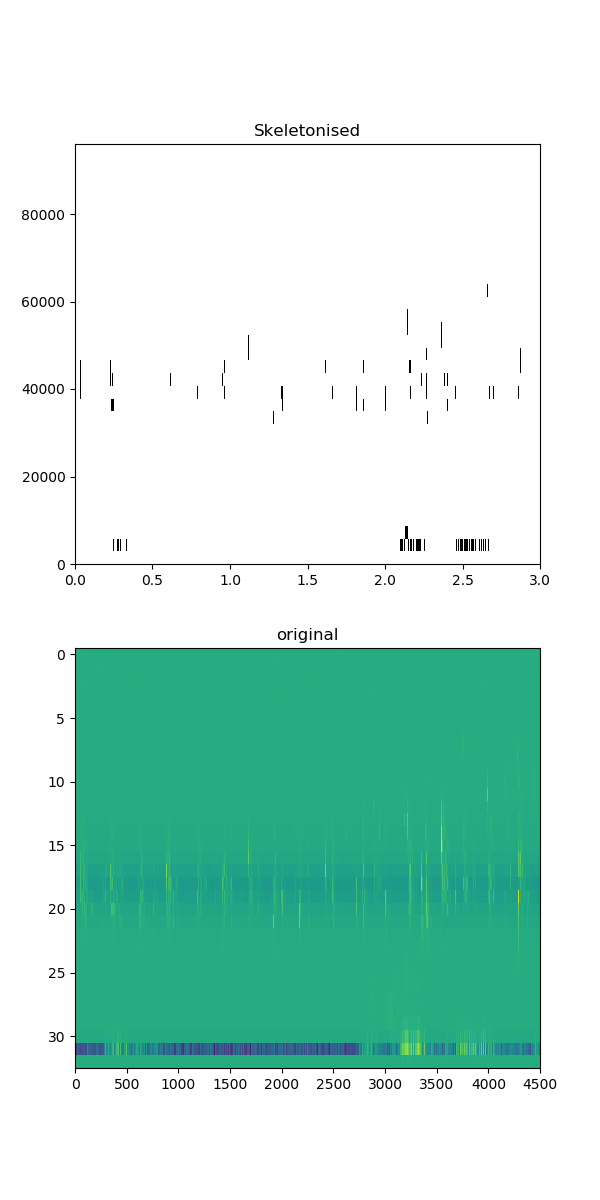

Text(0.5,1,'original')

In [195]:
plt.figure(figsize=(6,12))
plt.subplot(211)
plt.imshow(skeleton, aspect='auto', cmap='Greys', extent=[t[0]+start, t[-1]+stop, f[0], f[-1]])
plt.title('Skeletonised')
plt.subplot(212)
plt.imshow(log_meanS,  aspect='auto')
plt.title('original')

Skeletonisation too -- seems to do an *okay* job...

Let's now try canny edge detection : 

In [196]:
canny_filt = feature.canny(log_S, sigma=1)

<IPython.core.display.Javascript object>


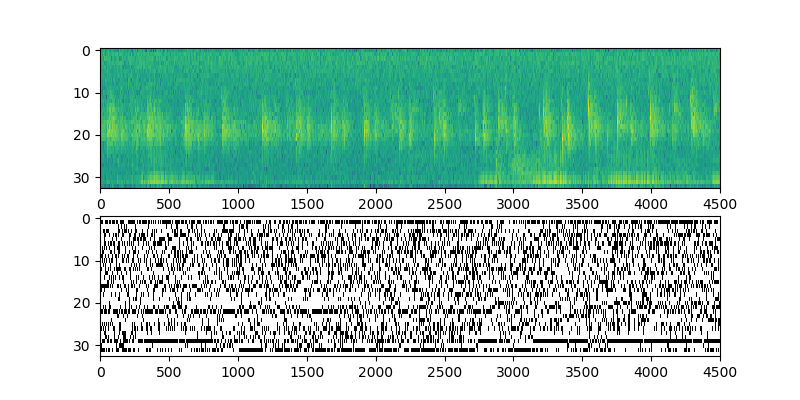

In [197]:

plt.figure(figsize=(8,4))
a = plt.subplot(211)
plt.imshow(log_S,  aspect='auto')
plt.subplot(212, sharex=a)
plt.imshow(canny_filt, aspect='auto', cmap='Greys')

Finally, let's try out contour detection as this might help to isolate the bat calls:

<IPython.core.display.Javascript object>


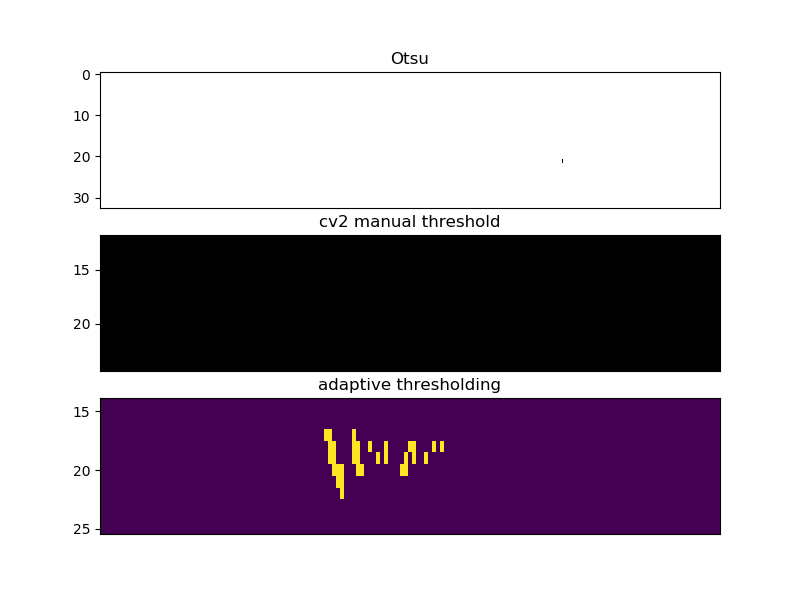

([], <a list of 0 Text xticklabel objects>)

In [198]:
plt.figure(figsize=(8,6))
plt.subplot(311)
plt.title('Otsu')
plt.imshow(S_8bit_otsu, aspect='auto', cmap='Greys')
plt.xticks([])
plt.subplot(312)
plt.imshow(thresh, aspect='auto', cmap='Greys')
plt.title('cv2 manual threshold')
plt.xticks([])
plt.subplot(313)
plt.title('adaptive thresholding')
plt.imshow(S_8bit_adap, aspect='auto')
plt.xticks([])



In [199]:
contours = measure.find_contours(S_8bit_adap, 0, fully_connected='high')

<IPython.core.display.Javascript object>


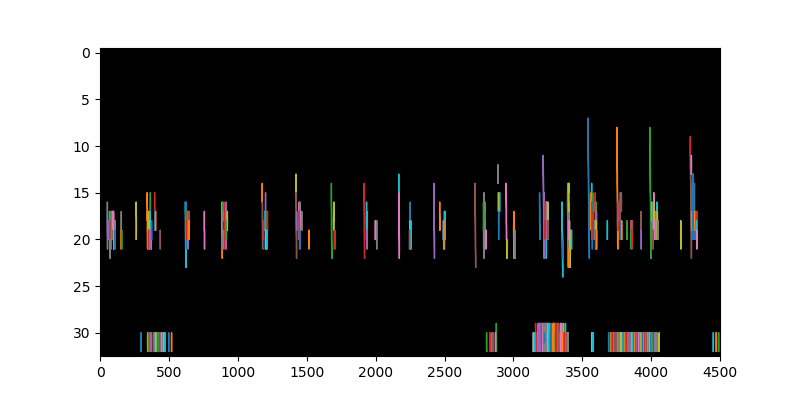

In [200]:
# Display the image and plot all contours found
plt.figure(figsize=(8,4))
plt.imshow(S_8bit_adap, aspect='auto', interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)
plt.show()

Contour finding works pretty well - though it could get a bit messy when the 

Let's now combine the skeleton with the contours...and see what happens ...:


<IPython.core.display.Javascript object>


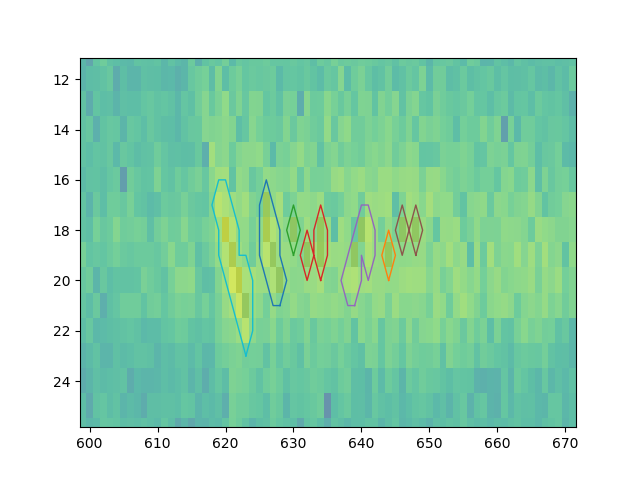

In [201]:
plt.figure()
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)
plt.imshow(log_S, aspect='auto', alpha=0.8)
plt.imshow(skeleton, aspect='auto', alpha=0.1, cmap='Greys')

So, here is the contour of the calls + the skeleton (not so visible, as they're dark yellow inside the contours). The idea is essentially to 
now use the two output methods to reliably extract the bat calls. 

*ONE problem with using local thresholding* : if I apply the same method for a long recording, faint calls will be ignored when there are loud calls, and faint calls will be detected in the presence of loud calls! 